In [95]:
import pandas as pd # 0.21.0
import numpy as np
from functools import reduce
from time import time

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [ ]:
#https://qiita.com/ynakayama/items/897cc932008bd5c0e452
#http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
#file:///home/tasuku/Downloads/Report.pdf
#http://ta-lib.org/d_api/ta_setunstableperiod.html

In [96]:
import talib as ta
ta.get_function_groups

<function talib.get_function_groups>

In [97]:
np.random.seed(100)
quandl.ApiConfig.api_key = "eFys5fhhsTNVrsJEcQ5y"

In [371]:
df = quandl.get("WIKI/"+"AAPL", start_date="10-01-09", end_date="17-10-17")
df.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-11,212.80,213.00,208.45,210.11,16508200.0,0.0,1.0,27.347766,27.373469,26.788730,27.002063,115557400.0
2010-01-12,209.19,209.77,206.42,207.72,21230700.0,0.0,1.0,26.883831,26.958369,26.527847,26.694915,148614900.0
2010-01-13,207.87,210.93,204.10,210.65,21639000.0,0.0,1.0,26.714192,27.107445,26.229695,27.071461,151473000.0


In [374]:
df.loc['2010-05-13']

Open           2.632200e+02
High           2.650000e+02
Low            2.564000e+02
Close          2.583600e+02
Volume         2.141830e+07
Ex-Dividend    0.000000e+00
Split Ratio    1.000000e+00
Adj. Open      3.382744e+01
Adj. High      3.405619e+01
Adj. Low       3.295097e+01
Adj. Close     3.320286e+01
Adj. Volume    1.499281e+08
Name: 2010-05-13 00:00:00, dtype: float64

In [375]:
df.shift(1).dropna().head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-12,212.80,213.00,208.45,210.11,16508200.0,0.0,1.0,27.347766,27.373469,26.788730,27.002063,115557400.0
2010-01-13,209.19,209.77,206.42,207.72,21230700.0,0.0,1.0,26.883831,26.958369,26.527847,26.694915,148614900.0
2010-01-14,207.87,210.93,204.10,210.65,21639000.0,0.0,1.0,26.714192,27.107445,26.229695,27.071461,151473000.0
2010-01-15,210.11,210.46,209.02,209.43,15460500.0,0.0,1.0,27.002063,27.047043,26.861983,26.914674,108223500.0
2010-01-19,210.93,211.60,205.87,205.93,21216700.0,0.0,1.0,27.107445,27.193549,26.457164,26.464875,148516900.0


In [376]:
def get_features(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    log_ret_df = get_log_returns(df['Adj. Close'])
    # Handle look ahead-bias
    shifted_df = df.shift(1)
    momentum_df = get_momentum_indicators(shifted_df)
    dfs = [shifted_df, log_ret_df,momentum_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs).dropna()
    return df_final

def get_log_returns(df):
    df_log =  pd.DataFrame(np.log(df/df.shift(1))).dropna()
    df_log = df_log.rename(index=str, columns={"Adj. Close": "log_ret"})
    return df_log

def get_momentum_indicators(df):
    # http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    momentum = dict()
    days = [7,14,28]
    for t in days:
        momentum['adx_{}'.format(t)] = ta.ADX(high, low, close, timeperiod=t)
        momentum['adxr_{}'.format(t)] = ta.ADXR(high, low, close, timeperiod=t)
        momentum['aroondown_{}'.format(t)], momentum['aroonup_{}'.format(t)] = ta.AROON(high, low, timeperiod=t)
        momentum['aroon_{}'.format(t)] = ta.AROONOSC(high, low, timeperiod=t)
        momentum['rsi_{}'.format(t)] = ta.RSI(close, timeperiod=t)
        momentum['mom_{}'.format(t)] = ta.MOM(close, timeperiod=t)
        momentum['roc_{}'.format(t)] = ta.ROC(close, timeperiod=t)
        momentum['willr_{}'.format(t)] = ta.WILLR(high, low, close, timeperiod=t)
        momentum['trix_{}'.format(t)] = ta.TRIX(close, timeperiod=t)
        
        
    momentum['apo'] = ta.APO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['macd'], momentum['macdsignal'], momentum['macdhist'] = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    momentum['ppo'] = ta.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['slowk'], momentum['slowd'] = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    momentum['fastk'], momentum['fastd'] = ta.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    momentum['fastkrsi'], momentum['fastdrsi'] = ta.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    
    df = pd.DataFrame.from_dict(momentum)
    df = df.set_index(df_index)
    return df

In [400]:
df = get_features("AAPL", "09-01-09", "17-10-17")

In [401]:
np.log(120.539169/120.974916)

-0.003608464266771136

In [402]:
#df = quandl.get("WIKI/"+"AAPL", start_date="15-01-09", end_date="17-10-17")
#log = get_log_returns(df['Adj. Close'])


In [403]:
np.log(103.787957/106.409968)

-0.024949313923774866

In [404]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,...,rsi_28,rsi_7,slowd,slowk,trix_14,trix_28,trix_7,willr_14,willr_28,willr_7
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-11,129.04,131.2342,126.26,129.19,16713000.0,0.0,1.0,16.583439,16.865424,16.226170,...,64.876549,60.495757,76.095047,57.050755,0.715031,0.721089,0.620529,-28.926174,-14.555893,-50.233100
2009-05-12,127.37,130.9600,127.12,129.57,14452100.0,0.0,1.0,16.368820,16.830185,16.336692,...,65.122501,62.002116,58.744366,42.841836,0.695927,0.716929,0.553445,-31.951220,-13.272543,-51.038961
2009-05-13,129.56,129.7100,123.25,124.42,21767200.0,0.0,1.0,16.650266,16.669543,15.839343,...,59.287581,38.680878,44.142250,32.534160,0.662808,0.710100,0.419887,-83.763838,-38.279933,-88.585366
2009-05-14,123.21,124.0200,119.38,119.49,21284700.0,0.0,1.0,15.834202,15.938299,15.341994,...,54.444807,27.238529,31.567373,19.326123,0.610933,0.699417,0.212593,-99.220963,-69.287834,-99.220963
2009-05-15,119.78,123.5300,119.70,122.95,15993800.0,0.0,1.0,15.393399,15.875327,15.383118,...,57.001104,41.425862,21.995211,14.125349,0.555215,0.686693,0.046641,-74.716714,-52.176063,-74.716714


In [405]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Ex-Dividend']
del df['Split Ratio']



In [406]:
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,rsi_28,rsi_7,slowd,slowk,trix_14,trix_28,trix_7,willr_14,willr_28,willr_7
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-11,16713000.0,16.583439,16.865424,16.226170,16.602716,116991000.0,0.002937,44.442148,26.325859,48.684727,...,64.876549,60.495757,76.095047,57.050755,0.715031,0.721089,0.620529,-28.926174,-14.555893,-50.233100
2009-05-12,14452100.0,16.368820,16.830185,16.336692,16.651551,101164700.0,-0.040558,43.374433,26.498747,42.731371,...,65.122501,62.002116,58.744366,42.841836,0.695927,0.716929,0.553445,-31.951220,-13.272543,-51.038961
2009-05-13,21767200.0,16.650266,16.669543,15.839343,15.989704,152370400.0,-0.040430,40.844949,26.290780,40.656313,...,59.287581,38.680878,44.142250,32.534160,0.662808,0.710100,0.419887,-83.763838,-38.279933,-88.585366


### Date, Time features

In [407]:
df['Date'] = df.index
#df[['year','month','day']] = df.Date.str.split('-',expand=True)
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,slowk,trix_14,trix_28,trix_7,willr_14,willr_28,willr_7,Date,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-11,16713000.0,16.583439,16.865424,16.226170,16.602716,116991000.0,0.002937,44.442148,26.325859,48.684727,...,57.050755,0.715031,0.721089,0.620529,-28.926174,-14.555893,-50.233100,2009-05-11,5,11
2009-05-12,14452100.0,16.368820,16.830185,16.336692,16.651551,101164700.0,-0.040558,43.374433,26.498747,42.731371,...,42.841836,0.695927,0.716929,0.553445,-31.951220,-13.272543,-51.038961,2009-05-12,5,12
2009-05-13,21767200.0,16.650266,16.669543,15.839343,15.989704,152370400.0,-0.040430,40.844949,26.290780,40.656313,...,32.534160,0.662808,0.710100,0.419887,-83.763838,-38.279933,-88.585366,2009-05-13,5,13


In [408]:
del df['Date']
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,slowd,slowk,trix_14,trix_28,trix_7,willr_14,willr_28,willr_7,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-11,16713000.0,16.583439,16.865424,16.226170,16.602716,116991000.0,0.002937,44.442148,26.325859,48.684727,...,76.095047,57.050755,0.715031,0.721089,0.620529,-28.926174,-14.555893,-50.233100,5,11
2009-05-12,14452100.0,16.368820,16.830185,16.336692,16.651551,101164700.0,-0.040558,43.374433,26.498747,42.731371,...,58.744366,42.841836,0.695927,0.716929,0.553445,-31.951220,-13.272543,-51.038961,5,12
2009-05-13,21767200.0,16.650266,16.669543,15.839343,15.989704,152370400.0,-0.040430,40.844949,26.290780,40.656313,...,44.142250,32.534160,0.662808,0.710100,0.419887,-83.763838,-38.279933,-88.585366,5,13


### Create lagged features

In [409]:
steps = 20
lags_df = (pd.concat(
    [df.log_ret.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_ret'] + ['log_ret_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict current steering.
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_ret'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [410]:

final_df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,log_ret_L10,log_ret_L11,log_ret_L12,log_ret_L13,log_ret_L14,log_ret_L15,log_ret_L16,log_ret_L17,log_ret_L18,log_ret_L19
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-08,22597000.0,18.674360,18.814440,18.404481,18.592111,158179000.0,-0.005684,33.954642,26.480935,52.193474,...,-0.013621,-0.013518,-0.012475,0.006297,0.033970,-0.004320,0.028545,-0.040430,-0.040558,0.002937
2009-06-09,33273300.0,18.482875,18.535565,17.918698,18.486730,232913100.0,-0.007886,34.108213,26.717750,49.721977,...,0.065405,-0.013621,-0.013518,-0.012475,0.006297,0.033970,-0.004320,0.028545,-0.040430,-0.040558
2009-06-10,24177300.0,18.481589,18.577975,18.062634,18.341509,169241100.0,-0.017458,34.304771,26.960771,47.818925,...,0.017208,0.065405,-0.013621,-0.013518,-0.012475,0.006297,0.033970,-0.004320,0.028545,-0.040430


In [411]:
# convert return into binary to format for classification
final_df["y"] = final_df.apply(lambda x: 1 if x['log_ret'] > 0 else 0 , axis=1)


In [412]:
del final_df["log_ret"]

In [413]:
y = final_df.pop("y")
X = final_df

In [414]:
print("y shape: {}".format(y.shape))
print("X shape: {}".format(X.shape))

y shape: (2106,)
X shape: (2106, 68)


### Assess distribution and statistics of data

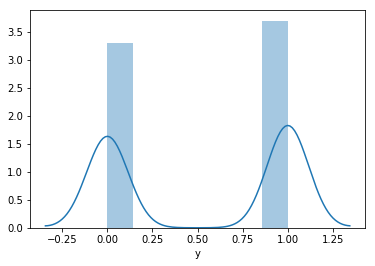

In [415]:

import seaborn as sns
%matplotlib inline
sns.distplot(y)

In [416]:
y.describe()

count    2106.000000
mean        0.528015
std         0.499333
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: y, dtype: float64

In [426]:
train_size = int(X.shape[0]*0.9)

### Split into train and test

In [427]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("y Train shape: {}".format(y_train.shape))
print("X Train shape: {}".format(X_train.shape))
print("y Test shape: {}".format(y_test.shape))
print("X Test shape: {}".format(X_test.shape))

y Train shape: (1895,)
X Train shape: (1895, 68)
y Test shape: (211,)
X Test shape: (211, 68)


### Train RandomForest classifier

In [431]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred) * 100))
print("RMSE for Random Forest Model: %.2f" % (rmse(y_test, pred) * 100))


Accuracy for Random Forest Model: 43.13
RMSE for Random Forest Model: 75.41
